## Variational AE

El VA-AE fue creado por Kingma y Welling en 2014. Este es un nuevo tipo y tiene algunas diferencias innovadoras:

- Son autocodificadores probabilísticos, lo que significa que sus salidas son en parte determinado por casualidad, incluso después del entrenamiento. 
- Más importante aún, son autocodificadores generativos, lo que significa que pueden generar nuevas instancias que parezcan haber sido muestreadas a partir de un sampleo del training set

El VA-AE es similar al Stacked o Convolutional AE con una adición: el encoder produce una media (u) y una desviación estándar (o). Estos parámetros van a ser usados para generar un sampleo aleatorio de una distribución gaussiana la cual sirve de entrada para el decoder quien se encarga del proceso generativo. La siguiente imagen muestra la arquitectura típica. 

<img src="img/ae1.png" />

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### Cargar las imagenes del Fashion MNIST

In [2]:
# CARGAR FASHION MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train.shape

(55000, 28, 28)

### Funciones de Utileria - Accuracy & Sampling

La clase Sampling genera utiliza la media y la desviacion standard para generar un vector aleatorio (sampled) de la distribucion normal generada con K.random_normal

In [3]:
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

**Encoder:**

Al igual que el Stacked AE contiene una serie de capas de entrada y una capa dense. La diferencia esta en la capa de salida que genere 3 outputs: mean, std y codings.

**Decoder:**

Este construye el modelo a partir de los codings generados por el Encoder. El resto del decoder sigue la misma estrategia del Stacked AE

**Latent Loss:**

Este modelo contiene 2 funciones de perdida, una que se aplica a cada instancia del batch (latent loss) y la otra que se aplica sobre el epoc (binary_crossentropy)

In [4]:
tf.random.set_seed(42)
np.random.seed(42)
codings_size = 10

# ENCODER
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z) # media
codings_log_var = keras.layers.Dense(codings_size)(z) # std
codings = Sampling()([codings_mean, codings_log_var]) # generacion de los codings del mean y std (Guasiana)
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# DECODER
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

# VARIATIONAL AE
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# LATENT LOSS
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)

# COMPILE & TRAIN
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 3s 55us/sample - loss: 0.3897 - rounded_accuracy: 0.8596 - val_loss: 0.3490 - val_rounded_accuracy: 0.8952
Epoch 2/25
55000/55000 [==============================] - 1s 25us/sample - loss: 0.3429 - rounded_accuracy: 0.8973 - val_loss: 0.3367 - val_rounded_accuracy: 0.9048
Epoch 3/25
55000/55000 [==============================] - 1s 25us/sample - loss: 0.3329 - rounded_accuracy: 0.9048 - val_loss: 0.3392 - val_rounded_accuracy: 0.8938
Epoch 4/25
55000/55000 [==============================] - 1s 25us/sample - loss: 0.3278 - rounded_accuracy: 0.9089 - val_loss: 0.3300 - val_rounded_accuracy: 0.9021
Epoch 5/25
55000/55000 [==============================] - 1s 25us/sample - loss: 0.3249 - rounded_accuracy: 0.9112 - val_loss: 0.3256 - val_rounded_accuracy: 0.9098
Epoch 6/25
55000/55000 [==============================] - 1s 25us/sample - loss: 0.3226 - rounded_accuracy: 0.9132 - val_loss:

### Funciones de Utileria (plot & display)

In [6]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

### Utilizar el VAR AE

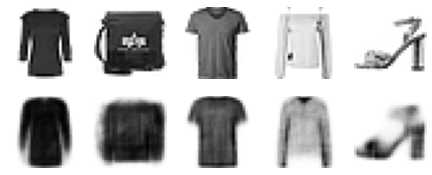

In [7]:
show_reconstructions(variational_ae)
plt.show()

### Generar Nuevas Imagenes

Ahora podemos generar nuevas imagenes a partir de los codings que podemos generar de forma aleatoria. Ojo que para generar nuevas imagenes no necesitamos el Encoder, solo el Decoder.

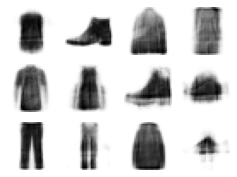

In [10]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

### Interpolacion Semantica

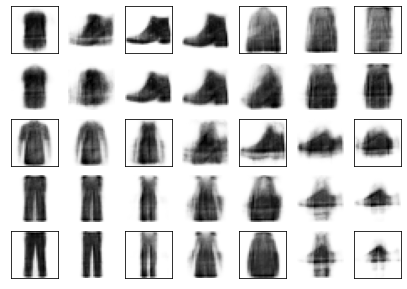

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")